In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random


# Tumors in Rats

In [7]:
data1 = pd.read_csv("/Users/brianxiang/Downloads/data.final.2024.Q3.csv")

## Standard MCMC

### Data and Set Up

We are measuring tumor incidence in rats across 15 different experiments. Our data consists of $n_i = $ the number of rats in each experiment $i$ and $y_i = $ the number of those rats that had tumors.

We design a Beta-Binomial hierarchical model as follows:

$$y_i \sim Bin(n_i, \theta_i)$$

$$\theta_i \sim Beta(\alpha, \beta)$$

with noninformative prior $p(\alpha, \beta) \propto 1$.

This gives us the following conditional distributions:

$$\theta_i | y_i, \alpha, \beta \sim Beta(y_i + \alpha, n_i - y_i + \beta)$$

$$p(\alpha, \beta | y, \theta) \propto (\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)})^{15}\prod_{i = 1}^{15}\theta_i^\alpha(1 - \theta_i)^\beta \Rightarrow$$

$$\ln(p(\alpha, \beta | y, \theta)) \propto -15\ln(\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}) + \sum_{i = 1}^{15} \alpha \ln(\theta_i) + \beta \ln(1 - \theta_i)$$

We use a Gibbs sampler with a Metropolis step to sample from the joint posterior distribution $\theta, \alpha, \beta | y$ using normal proposal distributions $\alpha^* \sim Norm(\alpha^{t - 1}. \nu_\alpha), \beta^* \sim Norm(\beta^{t - 1}. \nu_\beta)$ for each iteration $t$ with tuning parameter $\nu_\alpha, \nu_\beta$.



In [3]:
def logab(theta, a, b):
    if a <= 0 or b <= 0:
        return -float("inf")
    return -15 * np.log(scipy.special.beta(a, b)) + np.sum(a * np.log(theta) + b * np.log(1 - theta))

In [4]:
def chain(n, y, theta_init, alpha_init, beta_init, numsamp, atuning = 0.3, btuning = 1.1):
    accept = 0
    reject = 0
    
    theta_samps = np.zeros((numsamp, 15))
    alpha_samps = np.zeros(numsamp)
    beta_samps = np.zeros(numsamp)
    
    theta_samps[0] = theta_init
    alpha_samps[0] = alpha_init
    beta_samps[0] = beta_init
    
    for i in range(1, numsamp):        
        alpha_prop = np.random.normal(alpha_samps[i - 1], atuning)
        beta_prop = np.random.normal(beta_samps[i - 1], btuning)
        log_r = logab(theta_samps[i - 1], alpha_prop, beta_prop) - logab(theta_samps[i - 1], alpha_samps[i - 1], beta_samps[i - 1])
        log_u = np.log(random.uniform(0, 1))
        
        if log_u <= log_r:
            alpha_samps[i] = alpha_prop
            beta_samps[i] = beta_prop
            accept = accept + 1
            
        else:
            alpha_samps[i] = alpha_samps[i - 1]
            beta_samps[i] = beta_samps[i - 1]
            reject = reject + 1
            
        theta_samps[i] = np.random.beta(y + alpha_samps[i], n - y + beta_samps[i], 15)
        
    print("Acceptance Rate: ", accept/(accept + reject))
    
    return theta_samps, alpha_samps, beta_samps


### Initial Values and Tuning Parameters

We use two chain with inital values:

$$\alpha_1^{(0)} = 1, \beta_1^{(0)} = 2, \theta_{1i}^{(0)} \sim Beta(y_i + 1, n_i - y_i + 2)$$

and 

$$\alpha_2^{(0)} = 20, \beta_2^{(0)} = 50, \theta_{2i}^{(0)} \sim Beta(y_i + 20, n_i - y_i + 50)$$

We use tuning parameters $\nu_\alpha = 0.3, \nu_\beta = 1.1$ which were determined based on the acceptance rate ($\sim$75%).

In [5]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

theta_samps1, alpha_samps1, beta_samps1 = chain(n, y, theta_1, a_1, b_1, 10000)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps2, alpha_samps2, beta_samps2 = chain(n, y, theta_2, a_2, b_2, 10000)

Acceptance Rate:  0.7506750675067507
Acceptance Rate:  0.7612761276127613


In [6]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps1, beta_samps1, theta_samps1.T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps2, beta_samps2, theta_samps2.T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))

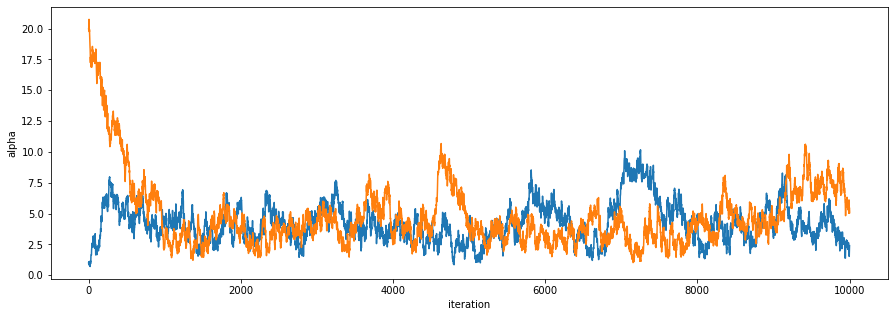

In [7]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

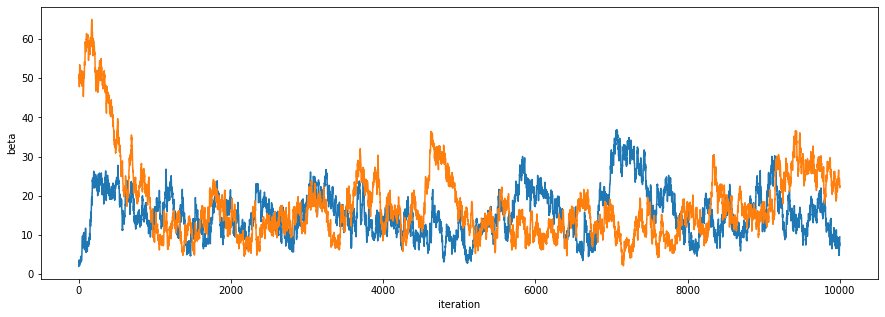

In [8]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

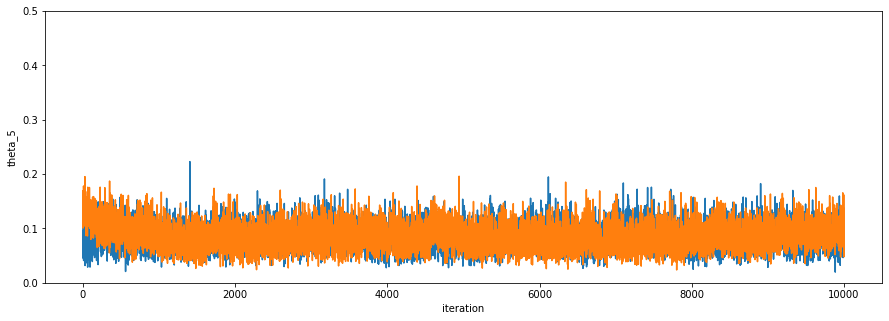

In [9]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

ax.set_ylim(0, 0.5)
plt.show()

## Unbiased MCMC

In [18]:
def ar(prev, prop, crit, log_pdf):
    log_r = log_pdf(prop) - log_pdf(prev)
    if crit <= log_r:
        return prop
    else:
        return prev

In [19]:
def sample_couple(prev_x, prev_y, tuning):
    log_p = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning * np.ones(len(prev_x)))
    log_q = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning * np.ones(len(prev_y)))
    
    x_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_x, tuning * np.ones(len(prev_x)))]).ravel()
    
    if np.log(random.uniform(0, 1)) <= log_q(x_prop) - log_p(x_prop):
        return x_prop, x_prop
    else:
        y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))]).ravel()
        while np.log(random.uniform(0, 1)) <= log_p(y_prop) - log_q(y_prop):
            y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))]).ravel()
            
        return x_prop, y_prop


In [12]:
def loga(alpha, beta, theta):
    if alpha <= 0:
        return -float("inf")
    return 15 * (np.log(scipy.special.gamma(alpha + beta)) - np.log(scipy.special.gamma(alpha))) + alpha * np.sum(np.log(theta))

In [13]:
def logb(alpha, beta, theta):
    if beta <= 0:
        return -float("inf")
    return 15 * (np.log(scipy.special.gamma(alpha + beta)) - np.log(scipy.special.gamma(beta))) + beta * np.sum(np.log(1 - theta))

In [14]:
def unbiased_rat_metropolis(n, y, theta_init1, alpha_init1, beta_init1, theta_init2, alpha_init2, beta_init2, numsamp, atuning = 0.3, btuning = 1.1, lag = 1):
    theta_samps1 = np.zeros((numsamp, 15))
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    
    theta_samps2 = np.zeros((numsamp - lag, 15))
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    
    theta_samps1[0] = theta_init1
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    
    theta_samps2[0] = theta_init2
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    
    cnta = 0
    cntb = 0
    cnttheta = np.zeros(15)
    
    converge = False
        
    for i in range(1, numsamp):
        if i <= lag:
            alpha_prop1 = np.random.normal(alpha_samps1[i - 1], atuning)
            logu = np.log(random.uniform(0, 1))
            alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda z: loga(z, beta_samps1[i - 1], theta_samps1[i - 1]))

            beta_prop1 = np.random.normal(beta_samps1[i - 1], btuning)
            logu = np.log(random.uniform(0, 1))
            beta_samps1[i] = ar(beta_samps1[i - 1], beta_prop1, logu, lambda z: logb(alpha_samps1[i], z, theta_samps1[i - 1]))

            theta_samps1[i] = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)

        else:
            alpha_prop1, alpha_prop2 = sample_couple(np.array([alpha_samps1[i - 1]]), np.array([alpha_samps2[i - lag - 1]]), atuning)
            logu = np.log(random.uniform(0, 1))
            alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda z: loga(z, beta_samps1[i - 1], theta_samps1[i - 1]))
            alpha_samps2[i - lag] = ar(alpha_samps2[i - lag - 1], alpha_prop2, logu, lambda z: loga(z, beta_samps2[i - lag - 1], theta_samps2[i - lag - 1]))

            beta_prop1, beta_prop2 = sample_couple(np.array([beta_samps1[i - 1]]), np.array([beta_samps2[i - lag - 1]]), btuning)
            logu = np.log(random.uniform(0, 1))
            beta_samps1[i] = ar(beta_samps1[i - 1], beta_prop1, logu, lambda z: logb(alpha_samps1[i], z, theta_samps1[i - 1]))
            beta_samps2[i - lag] = ar(beta_samps2[i - lag - 1], beta_prop2, logu, lambda z: logb(alpha_samps2[i - lag], z, theta_samps2[i - lag - 1]))

            theta_samps1[i] = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)
            theta_samps2[i - lag] = np.random.beta(y + alpha_samps2[i - lag], n - y + beta_samps2[i - lag], 15)

        if alpha_samps1[i] == alpha_samps2[i - lag] and beta_samps1[i] == beta_samps2[i - lag]:
            if not converge:
                print(i)
                converge = True
    if not converge:
        print("did not converge")
        
    return theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2


In [15]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2 = unbiased_rat_metropolis(n, y, theta_1, a_1, b_1, theta_2, a_2, b_2, 15000)

874


In [16]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps1[1:10001], beta_samps1[1:10001], theta_samps1[1:10001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps2[:10000], beta_samps2[:10000], theta_samps2[:10000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))

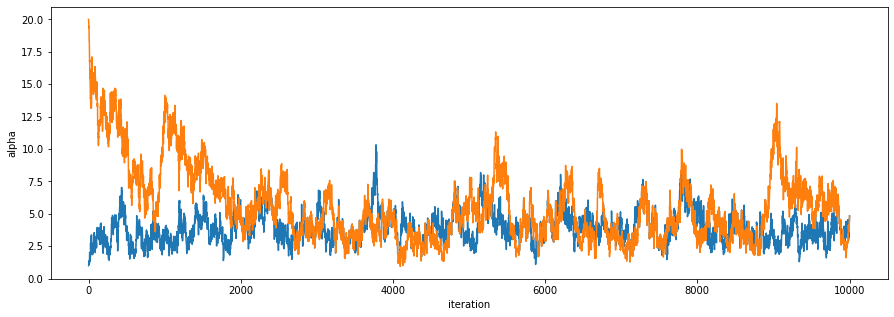

In [17]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

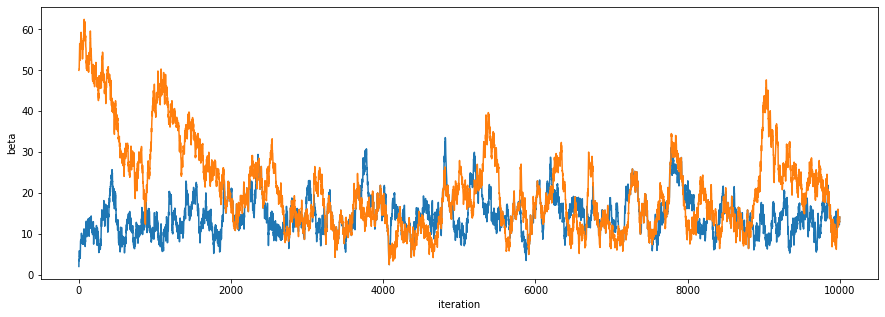

In [18]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

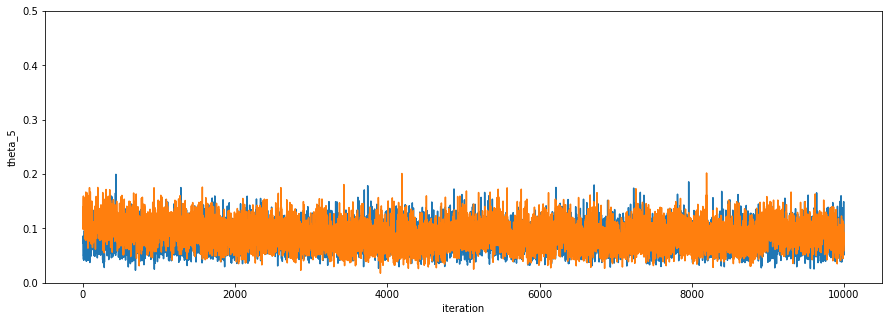

In [19]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

ax.set_ylim(0, 0.5)
plt.show()

# Total Traffic Data

In [8]:
data2 = pd.read_table("/Users/brianxiang/Downloads/bicycles-1.txt", sep = '\s+', header = 0)

Determine the amount of traffic on each street.

$$y_i \sim Poisson(\theta_i)$$
$$\theta_i \sim Gamma(\alpha, \beta)$$
$$p(\alpha, \beta) \propto 1$$

Poisson-Gamma HM

## Standard

In [21]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

In [22]:
def loga(y, alpha, beta, theta):
    if alpha <= 0:
        return -float("inf")
    else:
        n = len(y)
        return alpha * n * np.log(beta) - n * np.log(scipy.special.gamma(alpha)) + alpha * np.sum(np.log(theta))

In [23]:
def standard_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning, numsamp):
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    theta_samps1 = np.zeros((numsamp, len(y)))
    
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    theta_samps1[0] = theta_init1
    
    alpha_samps2 = np.zeros(numsamp)
    beta_samps2 = np.zeros(numsamp)
    theta_samps2 = np.zeros((numsamp, len(y)))
    
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    theta_samps2[0] = theta_init2
    
    for i in range(1, numsamp):
        theta_prop1 = np.random.gamma(alpha_samps1[i - 1] + y, scale = 1 / (beta_samps1[i - 1] + 1), size = len(y))
        theta_samps1[i] = theta_prop1
        
        beta_prop1 = np.random.gamma(alpha_samps1[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps1[i])))
        beta_samps1[i] = beta_prop1
    
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], tuning)
        logu = np.log(random.uniform(0, 1))
        alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda x: loga(y, x, beta_samps1[i], theta_samps1[i]))
        
        theta_prop2 = np.random.gamma(alpha_samps2[i - 1] + y, scale = 1 / (beta_samps2[i - 1] + 1), size = len(y))
        theta_samps2[i] = theta_prop2
        
        beta_prop2 = np.random.gamma(alpha_samps2[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps2[i])))
        beta_samps2[i] = beta_prop2
    
        alpha_prop2 = np.random.normal(alpha_samps2[i - 1], tuning)
        logu = np.log(random.uniform(0, 1))
        alpha_samps2[i] = ar(alpha_samps2[i - 1], alpha_prop2, logu, lambda x: loga(y, x, beta_samps2[i], theta_samps2[i]))
        
    return alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2

In [24]:
alpha_init1 = 50
beta_init1 = 20
theta_init1 = np.random.gamma(50 + y, 21, len(y))

alpha_init2 = 15
beta_init2 = 30
theta_init2 = np.random.gamma(15 + y, 31, len(y))

alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2 = standard_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning = 0.25, numsamp = 15000)

In [25]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 14000, 14000), alpha_samps1[1:14001], beta_samps1[1:14001], theta_samps1[1:14001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 14000, 14000), alpha_samps2[:14000], beta_samps2[:14000], theta_samps2[:14000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))

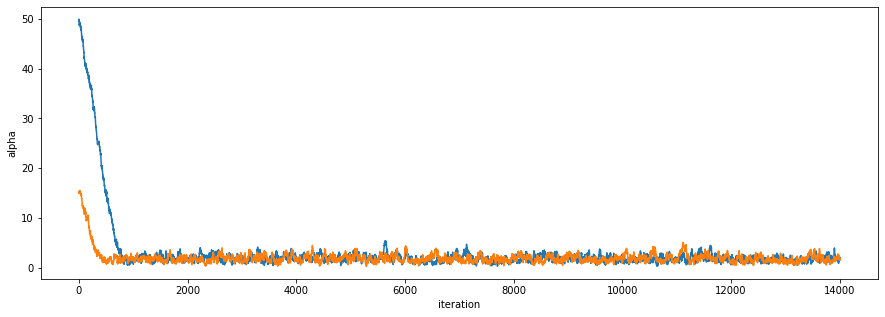

In [26]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

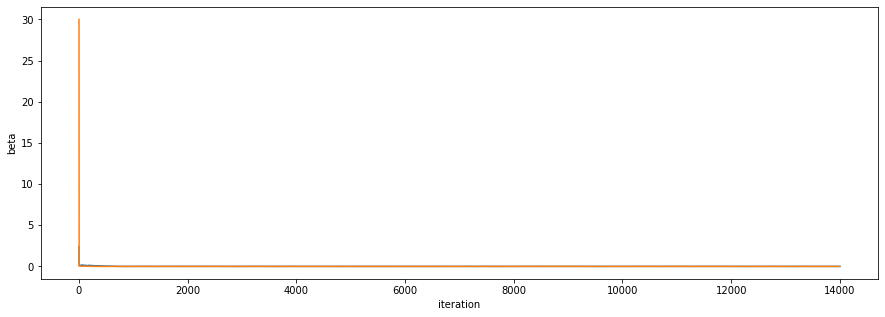

In [27]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

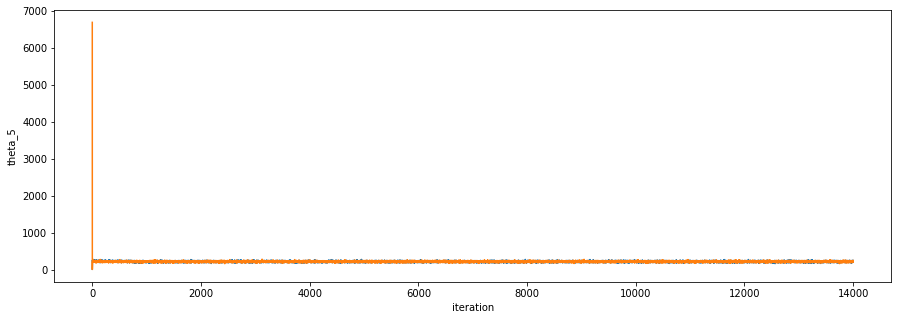

In [28]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Unbiased

In [66]:
def unbiased_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning, numsamp, lag = 1):
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    theta_samps1 = np.zeros((numsamp, len(y)))
    
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    theta_samps1[0] = theta_init1
    
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    theta_samps2 = np.zeros((numsamp - lag, len(y)))
    
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    theta_samps2[0] = theta_init2
    
    alpha_cnt = 0
    beta_cnt = 0
    theta_cnt = np.zeros(len(y))
    
    converge = False
    
    for i in range(1, numsamp):
        if lag >= i:
            theta_samps1[i] = np.random.gamma(alpha_samps1[i - 1] + y, scale = 1 / (beta_samps1[i - 1] + 1), size = len(y))
            beta_samps1[i] = np.random.gamma(alpha_samps1[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps1[i])))

            alpha_prop1 = np.random.normal(alpha_samps1[i - 1], tuning)
            logu = np.log(random.uniform(0, 1))
            alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda x: loga(y, x, beta_samps1[i], theta_samps1[i]))
            
        if lag < i:
            theta_samps1[i] = np.random.gamma(alpha_samps1[i - 1] + y, scale = 1 / (beta_samps1[i - 1] + 1), size = len(y))
            theta_samps2[i - lag] = np.random.gamma(alpha_samps2[i - lag - 1] + y, scale = 1 / (beta_samps2[i - lag - 1] + 1), size = len(y))

            beta_samps1[i] = np.random.gamma(alpha_samps1[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps1[i])))
            beta_samps2[i - lag] = np.random.gamma(alpha_samps2[i - lag - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps2[i - lag])))

            alpha_prop1, alpha_prop2 = sample_couple(np.array([alpha_samps1[i - 1]]), np.array([alpha_samps2[i - lag - 1]]), tuning)
            logu = np.log(random.uniform(0, 1))
            alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda x: loga(y, x, beta_samps1[i], theta_samps1[i]))
            alpha_samps2[i - lag] = ar(alpha_samps2[i - lag - 1], alpha_prop2, logu, lambda x: loga(y, x, beta_samps2[i - lag], theta_samps2[i - lag]))

        if alpha_samps1[i] == alpha_samps2[i - lag] and beta_samps1[i] == beta_samps2[i - lag]:
            if not converge:
                print(i)
                converge = True
    if not converge:
        print("Did not converge")
        
    return alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2

In [67]:
alpha_init1 = 50
beta_init1 = 20
theta_init1 = np.random.gamma(50 + y, 21, len(y))

alpha_init2 = 15
beta_init2 = 30
theta_init2 = np.random.gamma(15 + y, 31, len(y))

alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2 = unbiased_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning = 0.25, numsamp = 15000)

Did not converge


In [68]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps1[1:10001], beta_samps1[1:10001], theta_samps1[1:10001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps2[:10000], beta_samps2[:10000], theta_samps2[:10000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))

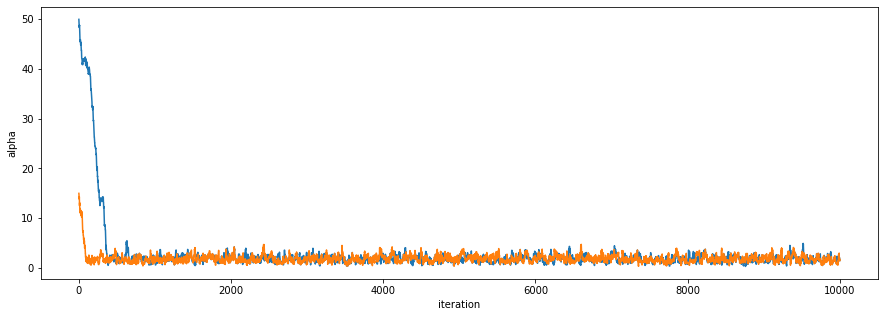

In [69]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

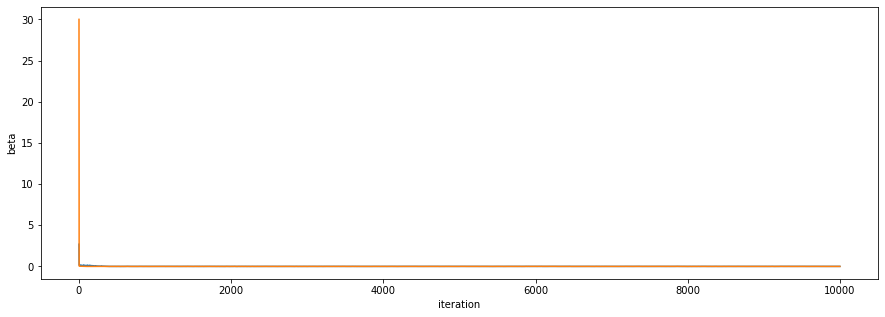

In [70]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

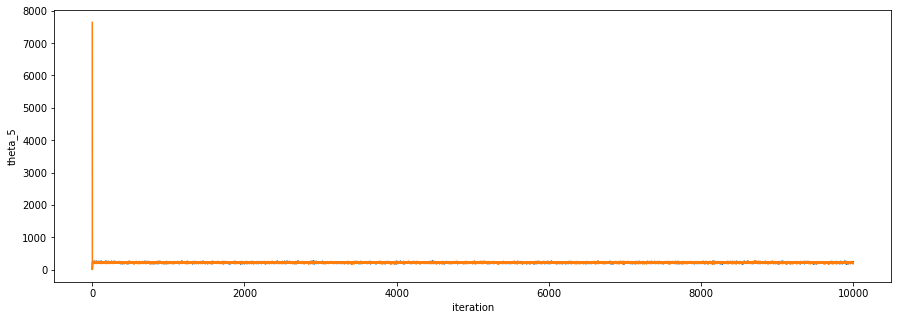

In [71]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Useful Functions

In [71]:
def sample_couple(prev_x, prev_y, tuning):
    log_p = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning * np.ones(len(prev_x)))
    log_q = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning * np.ones(len(prev_y)))
    
    x_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_x, tuning * np.ones(len(prev_x)))]).ravel()
    
    if np.log(random.uniform(0, 1)) <= log_q(x_prop) - log_p(x_prop):
        return x_prop, x_prop
    else:
        y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))]).ravel()
        while np.log(random.uniform(0, 1)) <= log_p(y_prop) - log_q(y_prop):
            y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))]).ravel()
            
        return x_prop, y_prop


In [72]:
def ar(prev, prop, crit, log_pdf):
    log_r = log_pdf(prop) - log_pdf(prev)
    if crit <= log_r:
        return prop, 1
    else:
        return prev, 0

In [73]:
def equality(px, py):
    if all (px[-1] == py[-1]):
        return True
    else:
        return False

In [74]:
def log_bb(data, params):
    if any(params <= 0) or any(params[2:] > 1):
        return -float("inf")
    else:
        return -15 * np.log(scipy.special.beta(params[0], params[1])) + np.sum((data[0] + params[0] - 1) * np.log(params[2:])) + np.sum((data[1] - data[0] + params[1] - 1) * np.log(1 - params[2:]))

In [75]:
def log_pg(data, params):
    if any(params <= 0):
        return -float("inf")
    else:
        n = len(data)
        return params[0] * n * np.log(params[1]) - n * np.log(scipy.special.gamma(params[0])) + np.sum((params[0] + data - 1) * np.log(params[2:])) - np.sum((params[1] + 1) * params[2:])

In [76]:
def log_ab(data, params):
    if any(params[-1] <= 0):
        return -float("inf")
    else:
        return -15 * np.log(scipy.special.beta(params[-1][0], params[-1][1])) + params[-1][0] * np.sum(np.log(params[0])) + params[-1][1] * np.sum(np.log(1 - params[0]))

In [77]:
def log_a(data, params):
    if params[-1][0] <= 0:
        return -float("inf")
    else:
        return 10 * params[-1][0] * np.log(params[0][0]) - 10 * np.log(scipy.special.gamma(params[-1][0])) + params[-1][0] * np.sum(np.log(params[1]))

# Unbiased Method \#1

Fully Metropolis

In [78]:
def coupled_metropolis1(data, x_init, y_init, logpdf_fun, k = 100, lag = 1):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    ss = np.power(x_init, 2) + np.power(y_init, 2)
    s = x_init + y_init

    accept = 2
    total = 2
    iteration = 0
    
    tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 

    c = (accept / total - 0.3)/total
    
    logpdf = lambda z: logpdf_fun(data, z)

    while not all(params_x[-1] == params_y[-1]):
        if lag <= iteration:
            x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], np.sqrt(np.exp(c) * tuning))
            log_u = np.log(random.uniform(0, 1))
            nextx, ax = ar(params_x[-1], x_prop, log_u, logpdf)
            params_x.append(nextx)
            nexty, ay = ar(params_y[-1], y_prop, log_u, logpdf)
            params_y.append(nexty)
            accept += ax + ay
            total += 2

            ss += np.power(nextx, 2) + np.power(nexty, 2)
            s += nextx + nexty
            
            tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 

            c = c + (accept / total - 0.3)/total
            
        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1])))
            log_u = np.log(random.uniform(0, 1))
            nextx, ax = ar(params_x[-1], x_prop, log_u, logpdf)
            params_x.append(nextx)
            accept += ax
            total += 1

            ss += np.power(nextx, 2)
            s += nextx

            tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 

            c = c + (accept / total - 0.3)/total
        
        iteration += 1
        
        if iteration == 1000000:
            break
    
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    iteration = 0
    
    while not all(params_x[-1] == params_y[-1]):
        if lag <= iteration:

            x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], np.sqrt(np.exp(c) * tuning))
            log_u = np.log(random.uniform(0, 1))
            nextx, ax = ar(params_x[-1], x_prop, log_u, logpdf)
            params_x.append(nextx)
            nexty, ay = ar(params_y[-1], y_prop, log_u, logpdf)
            params_y.append(nexty)
            
        else:

            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1])))
            log_u = np.log(random.uniform(0, 1))
            nextx, ax = ar(params_x[-1], x_prop, log_u, logpdf)
            params_x.append(nextx)

        iteration += 1
        
        if iteration == 1000000:
            break
        
    print(iteration)
    
    for i in range(k):
        x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1])))
        log_u = np.log(random.uniform(0, 1))
        nextx, ax = ar(params_x[-1], x_prop, log_u, logpdf)
        params_x.append(nextx)
        params_y.append(nextx)
        
    return params_x, params_y, iteration
    

In [548]:
# def coupled_metropolis1(data, x_init, y_init, logpdf_fun, tuning, k = 100, lag = 1):
#     params_x = [np.array(x_init)]
#     params_y = [np.array(y_init)]
    
#     iteration = 0
    
#     logpdf = lambda z: logpdf_fun(data, z)
    
#     while not all(params_x[-1] == params_y[-1]):
#         if lag <= iteration:
#             x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], tuning)
#             log_u = np.log(random.uniform(0, 1))
#             params_x.append(ar(params_x[-1], x_prop, log_u, logpdf)[0])
#             params_y.append(ar(params_y[-1], y_prop, log_u, logpdf)[0])
#         else:
#             x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
#             log_u = np.log(random.uniform(0, 1))
#             params_x.append(ar(params_x[-1], x_prop, log_u, logpdf)[0])
        
#         iteration += 1
        
#         if iteration == 10000:
#             break
        
#     print(iteration)
    
#     for i in range(k):
#         x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
#         logu = np.log(random.uniform(0, 1))
#         temp = ar(params_x[-1], x_prop, logu, logpdf)[0]
#         params_x.append(temp)
#         params_y.append(temp)
        
#     return params_x, params_y, iteration
    

## Rat

In [30]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, log_bb)#, tuning = np.array([0.3, 1.1] + [0.01] * len(y)))

1000000


In [31]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

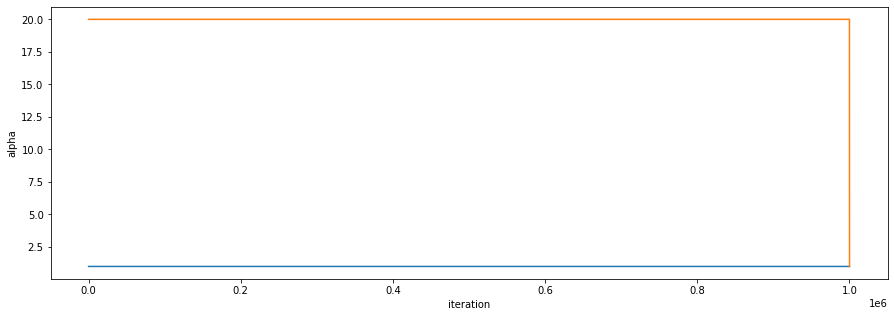

In [32]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

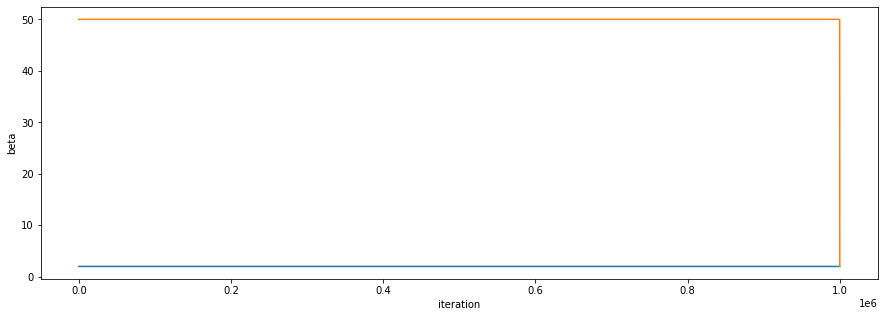

In [33]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

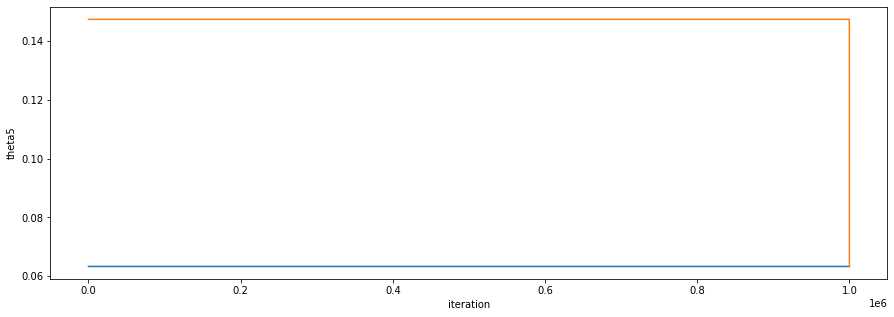

In [34]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

In [36]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

In [37]:
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, log_pg)#, tuning = np.array([0.3, 0.3] + [10] * len(y)))

165446


In [38]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

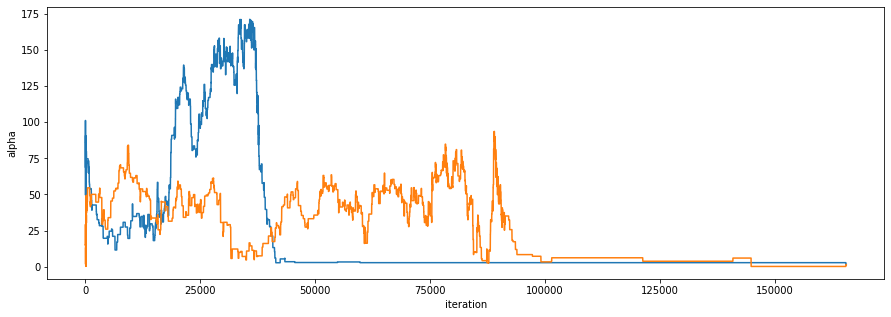

In [39]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

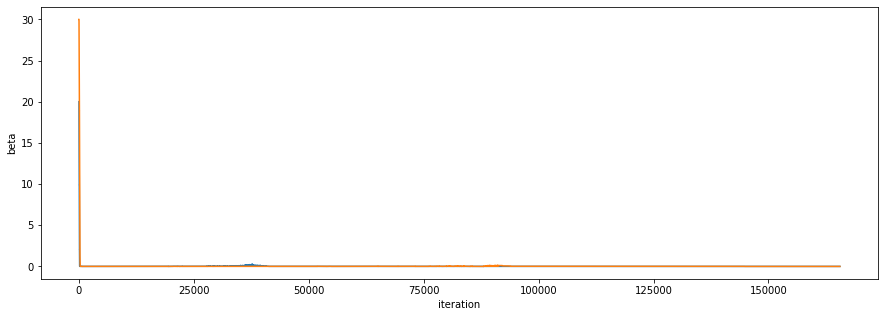

In [40]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

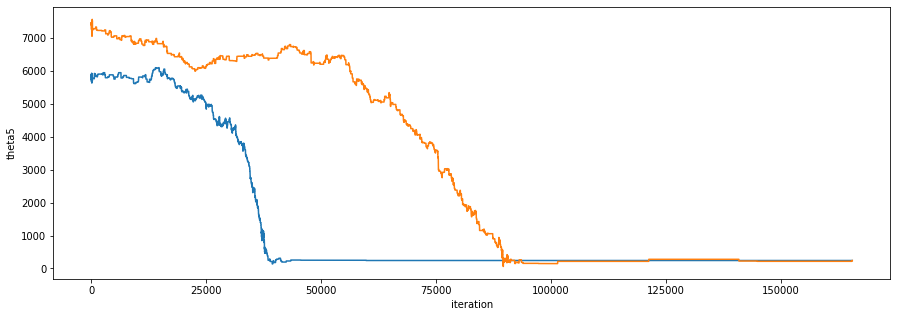

In [41]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Unbiased Method \#2

Metropolis step within Gibbs sampler

In [562]:
# def coupled_metropolis2(data, x_init, y_init, logpdf_fun, tuning, k = 100, lag = 1):
#     params_x = [np.array(x_init)]
#     params_y = [np.array(y_init)]
    
#     iteration = 0
    
#     while not all(params_x[-1] == params_y[-1]):
#         if lag <= iteration:
#             x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], tuning)

#             for j in range(len(x_prop)):
#                 logu = np.log(random.uniform(0, 1))
#                 x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))
#                 y_prop[j] = ar(params_y[-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:]))))
            
#             params_x.append(x_prop)
#             params_y.append(y_prop)

#         else:
#             x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
            
#             for j in range(len(x_prop)):
#                 logu = np.log(random.uniform(0, 1))
#                 x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))

#             params_x.append(x_prop)
            
#         iteration += 1
#         if iteration == 10000:
#             break
        
#     print(iteration)
    
#     for i in range(k):
#         x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
#         for j in range(len(x_prop)):
#             logu = np.log(random.uniform(0, 1))
#             x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))

#         params_x.append(x_prop)
#         params_y.append(x_prop)
        
#     return params_x, params_y, iteration
    

In [79]:
def coupled_metropolis2(data, x_init, y_init, logpdf_fun, k = 100, lag = 1):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    ss = np.power(x_init, 2) + np.power(y_init, 2)
    s = x_init + y_init

    accept = np.array([2] * len(x_init))
    total = 2
    iteration = 0
    
    tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 
    c = (accept / total - 0.3)/total
    
    while not all(params_x[-1] == params_y[-1]):
        if lag <= iteration:
            x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], np.sqrt(np.exp(c) * tuning))

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))

                x_prop[j], ax = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))
                y_prop[j], ay = ar(params_y[-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:]))))

                accept[j] += ax + ay
            total += 2

            ss += np.power(x_prop, 2) + np.power(y_prop, 2)
            s += x_prop + y_prop
                
            tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 
    
            c = c + (accept / total - 0.3)/total
                
            params_x.append(x_prop)
            params_y.append(y_prop)

        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1])))
            
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))

                x_prop[j], ax = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))

                accept[j] += ax
            total += 1

            ss += np.power(x_prop, 2)
            s += x_prop
                
            tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 
    
            c = c + (accept / total - 0.3)/total
                
            params_x.append(x_prop)
                        
        iteration += 1
        if iteration == 10000:
            break
            
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    iteration = 0

    while not all(params_x[-1] == params_y[-1]):
        if lag <= iteration:
            x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], np.sqrt(np.exp(c) * tuning))

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))

                x_prop[j], ax = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))
                y_prop[j], ay = ar(params_y[-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:]))))

            params_x.append(x_prop)
            params_y.append(y_prop)

        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1])))
            
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))

                x_prop[j], ax = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))

            params_x.append(x_prop)
                        
        iteration += 1
        if iteration == 10000:
            break

    print(iteration)
    
    for i in range(k):
        x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1])))
        for j in range(len(x_prop)):
            logu = np.log(random.uniform(0, 1))
            x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]

        params_x.append(x_prop)
        params_y.append(x_prop)
        
    return params_x, params_y, iteration
    

## Rat

In [80]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, log_bb)#, tuning = np.array([0.3, 1.1] + [0.01] * 15), k = 1000)

104


In [81]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

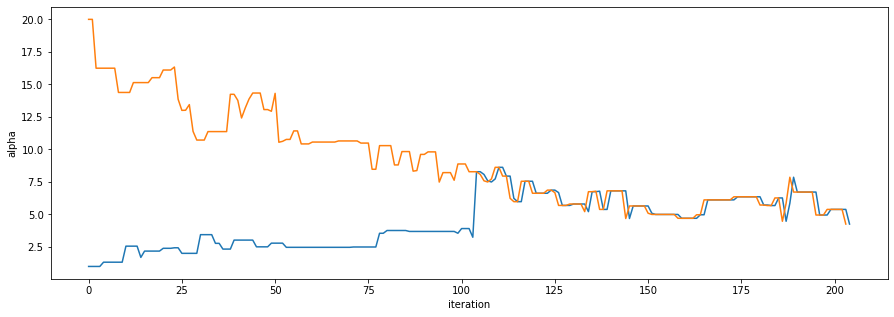

In [82]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

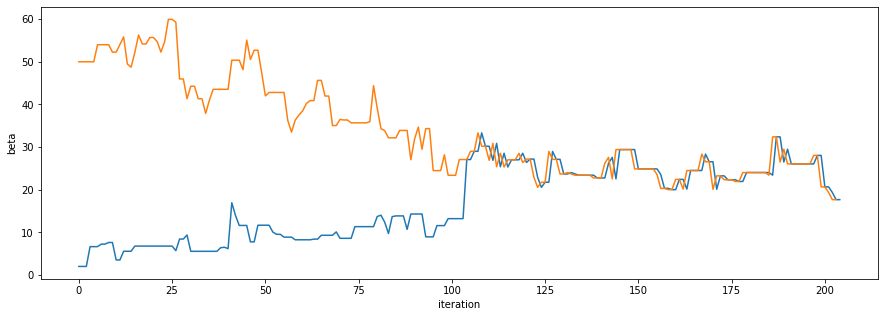

In [83]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

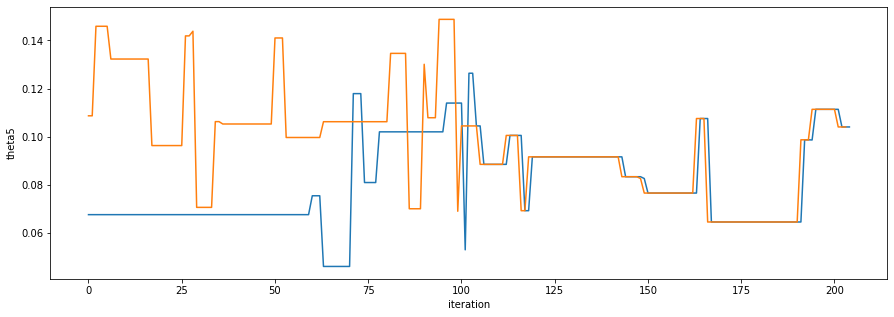

In [84]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

In [85]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

In [86]:
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, log_pg) #tuning = np.array([2.7, 0.3] + [500] * len(y)))

546


In [87]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

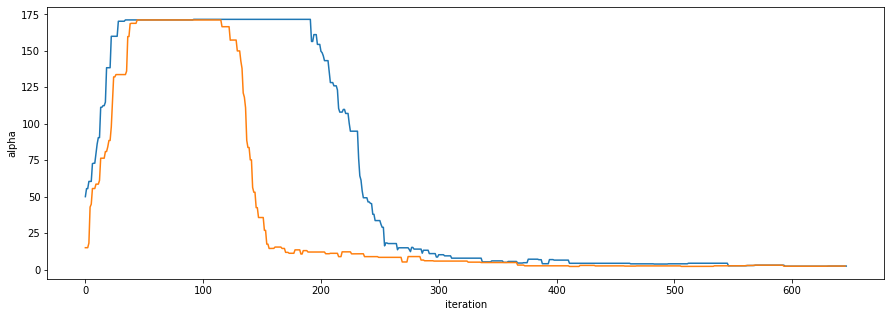

In [88]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

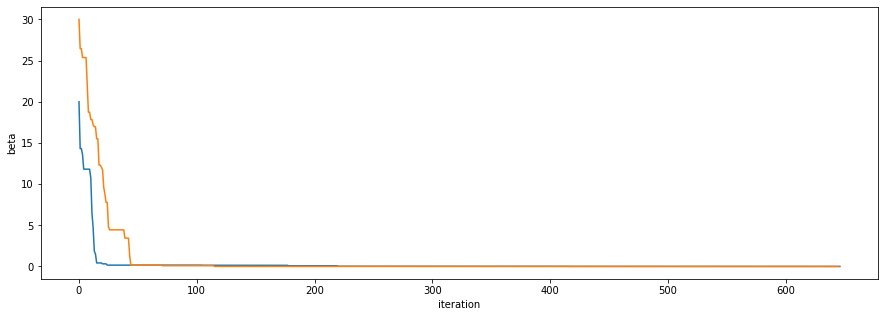

In [89]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

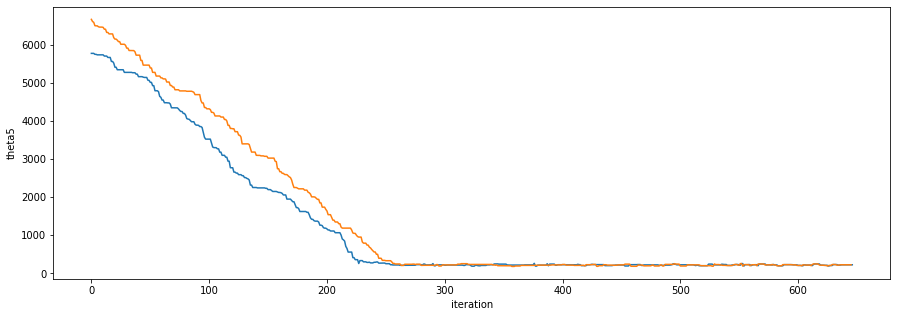

In [90]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Unbiased Method \#3

Gibbs sampler

In [103]:
# def coupled_metropolis_gibbs(data, x_init, y_init, converge_fun, logpdf_fun, tuning, gibbs_vec, k = 100, lag = 1):
#     params_x = [x_init]
#     params_y = [y_init]
    
#     iteration = 0
    
#     while not converge_fun(params_x[-1], params_y[-1]):
#         if lag <= iteration:
#             temp_x = np.zeros(len(x_init), dtype = 'object')
#             temp_y = np.zeros(len(x_init), dtype = 'object')

#             for j in range(len(gibbs_vec)):
#                 temp_x[j] = gibbs_vec[j](data, params_x[-1])
#                 temp_y[j] = gibbs_vec[j](data, params_y[-1])

#             x_prop, y_prop = sample_couple(params_x[-1][-1], params_y[-1][-1], tuning)

#             for j in range(len(x_prop)):
#                 logu = np.log(random.uniform(0, 1))
#                 x_prop[j] = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
#                 y_prop[j] = ar(params_y[-1][-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][j + 1:]))], dtype = 'object')))
            
#             temp_x[-1] = x_prop
#             temp_y[-1] = y_prop
            
#             params_x.append(temp_x)
#             params_y.append(temp_y)

#         else:
#             temp_x = np.zeros(len(x_init), dtype = 'object')
#             for j in range(len(gibbs_vec)):
#                 temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
#             x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning * np.ones(len(params_x[-1][-1])))]).ravel()

#             for j in range(len(x_prop)):
#                 logu = np.log(random.uniform(0, 1))                
#                 x_prop[j] = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
            
#             temp_x[-1] = x_prop
            
#             params_x.append(temp_x)            
            
#         iteration += 1
#         if iteration == 10000:
#             break
        
#     print(iteration)
    
#     for i in range(k):
#         temp_x = np.zeros(len(x_init), dtype = 'object')
#         for j in range(len(gibbs_vec)):
#             temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
#         x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning * np.ones(len(params_x[-1][-1])))]).ravel()

#         for j in range(len(x_prop)):
#             logu = np.log(random.uniform(0, 1))
#             x_prop[j] = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))

#         temp_x[-1] = x_prop

#         params_x.append(temp_x)   
#         params_y.append(temp_x)

#     return params_x, params_y, iteration
    

In [92]:
def coupled_metropolis_gibbs(data, x_init, y_init, converge_fun, logpdf_fun, tuning, gibbs_vec, k = 100, lag = 1):
    params_x = [x_init]
    params_y = [y_init]
    ss = np.power(x_init[-1], 2) + np.power(y_init[-1], 2)
    s = x_init[-1] + y_init[-1]

    accept = np.array([2] * len(x_init[-1]))
    total = 2
    iteration = 0
    
    tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 
    c = (accept / total - 0.3)/total
    
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            temp_y = np.zeros(len(x_init), dtype = 'object')

            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                temp_y[j] = gibbs_vec[j](data, params_y[-1])

            x_prop, y_prop = sample_couple(params_x[-1][-1], params_y[-1][-1], np.sqrt(np.exp(c) * tuning))

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                y_prop[j], ay = ar(params_y[-1][-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][j + 1:]))], dtype = 'object')))

                accept[j] += ax + ay
            total += 2

            ss = ss.astype("float") + np.power(x_prop, 2) + np.power(y_prop, 2)
            s = s.astype("float") + x_prop + y_prop
                
            tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 
    
            c = c + (accept / total - 0.3)/total
            
            temp_x[-1] = x_prop
            temp_y[-1] = y_prop
            
            params_x.append(temp_x)
            params_y.append(temp_y)

        else:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1][-1])))]).ravel()

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))                
                x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                
                accept[j] += ax
            total += 1
            
            ss = ss.astype("float") + np.power(x_prop, 2)

            s = s.astype("float") + x_prop
                
            tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 
    
            c = c + (accept / total - 0.3)/total
            
            temp_x[-1] = x_prop
            
            params_x.append(temp_x)            
            
        iteration += 1
        if iteration == 10000:
            break

    params_x = [x_init]
    params_y = [y_init]
    iteration = 0
            
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            temp_y = np.zeros(len(x_init), dtype = 'object')

            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                temp_y[j] = gibbs_vec[j](data, params_y[-1])

            x_prop, y_prop = sample_couple(params_x[-1][-1], params_y[-1][-1], np.sqrt(np.exp(c) * tuning))

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                y_prop[j], ay = ar(params_y[-1][-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            temp_y[-1] = y_prop
            
            params_x.append(temp_x)
            params_y.append(temp_y)

        else:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1][-1])))]).ravel()

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))                
                x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            
            params_x.append(temp_x)            
            
        iteration += 1
        if iteration == 10000:
            break  
            
    print(iteration)
    
    for i in range(k):
        temp_x = np.zeros(len(x_init), dtype = 'object')
        for j in range(len(gibbs_vec)):
            temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
        x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1][-1])))]).ravel()

        for j in range(len(x_prop)):
            logu = np.log(random.uniform(0, 1))
            x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))

        temp_x[-1] = x_prop

        params_x.append(temp_x)   
        params_y.append(temp_x)

    return params_x, params_y, iteration
    

## Rat

In [93]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.array((np.array(theta_1), np.array([a_1, b_1])), dtype = 'object')
y_init = np.array((np.array(theta_2), np.array([a_2, b_2])), dtype = 'object')

thetas = lambda data, params: np.random.beta(data[0] + params[-1][0], data[1] - data[0] + params[-1][1], 15)
gibbs_vec = [thetas]

params_x, params_y, iteration = coupled_metropolis_gibbs(data, x_init, y_init, equality, log_ab, tuning = np.array([0.3, 1.1]), gibbs_vec = gibbs_vec, k = 1000)


140


In [94]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

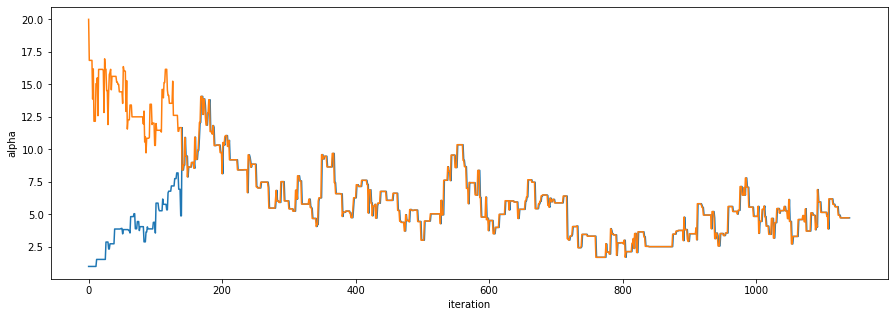

In [95]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

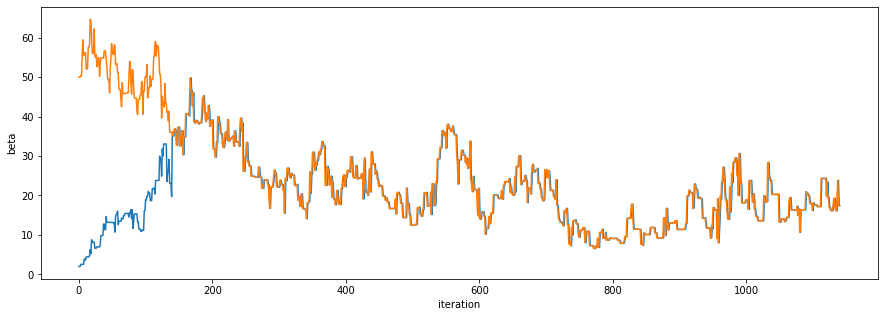

In [96]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

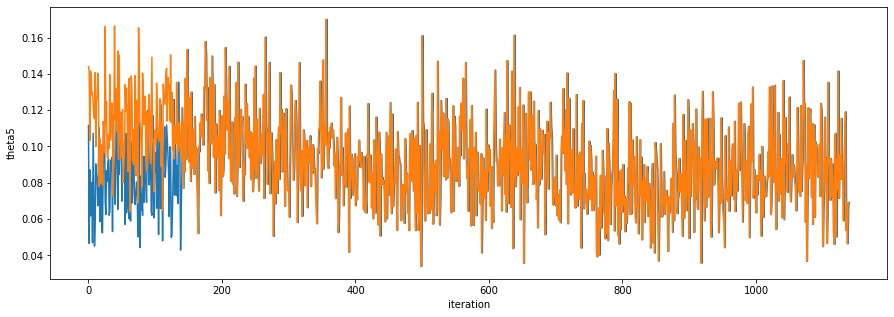

In [97]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

In [98]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()
data = [y]

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.array((np.array([b_1]), np.array(theta_1), np.array([a_1])), dtype = 'object')
y_init = np.array((np.array([b_2]), np.array(theta_2), np.array([a_2])), dtype = 'object')

beta = lambda data, params: np.array([np.random.gamma(10 * params[-1][0] + 1, scale = 1 / (np.sum(params[1])))])
thetas = lambda data, params: np.random.gamma(params[-1][0] + data[0], scale = 1 / (params[0][0] + 1), size = 10)
gibbs_vec = [beta, thetas]

params_x, params_y, iteration = coupled_metropolis_gibbs(data, x_init, y_init, equality, log_a, tuning = np.array([0.3]), gibbs_vec = gibbs_vec, k = 1000)


17


In [99]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'alpha'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'alpha'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

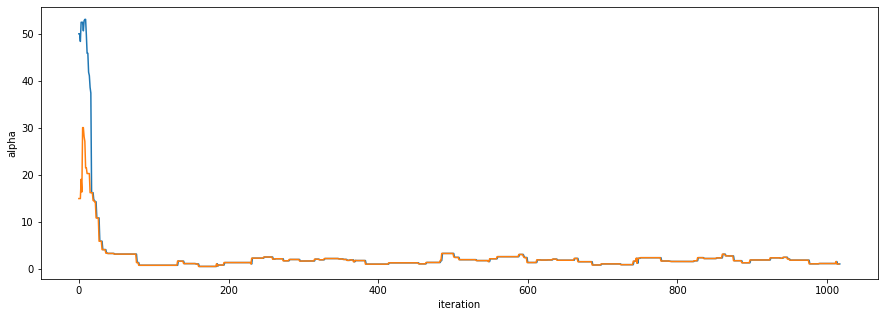

In [100]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

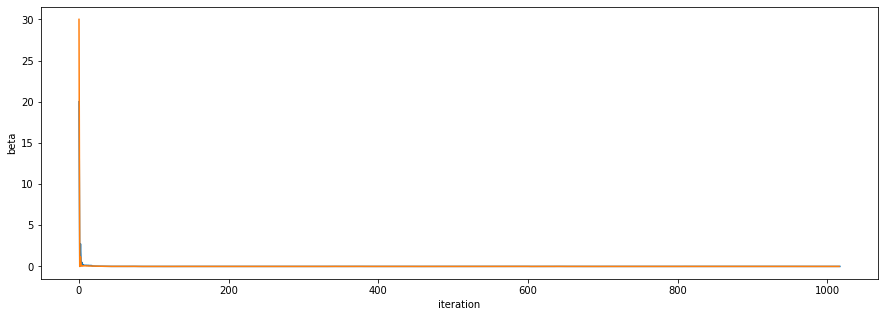

In [101]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

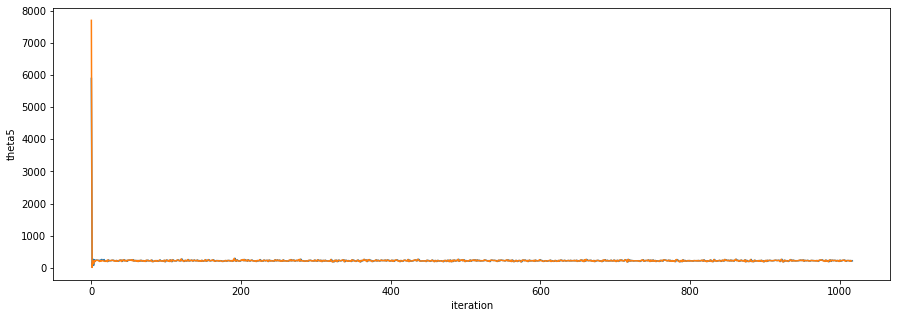

In [102]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Logistic Regression

$$p(y, x | \theta) = \prod_{i = 1}^n p_i(\theta)^{y_i}(1 - p_i(\theta))^{1 - y_i} = $$

$$\prod_{i = 1}^n \frac{e^{y_i\langle x_i, \theta\rangle}}{(1 + e^{\langle x_i, \theta\rangle})^{y_i}} \cdot \frac{1}{(1 + e^{\langle x_i, \theta\rangle})^{1 - y_i}} = $$

$$\prod_{i = 1}^n \frac{e^{y_i\langle x_i, \theta\rangle}}{1 + e^{\langle x_i, \theta\rangle}}$$


## Model \#1

$$p(\theta_i) \propto 1$$

$$p(\theta | y, x) = p(y, x | \theta) \propto \prod_{i = 1}^n \frac{e^{y_i\langle x_i, \theta\rangle}}{1 + e^{\langle x_i, \theta\rangle}} = \prod_{i = 1}^n \frac{e^{y_i x_i\theta}}{1 + e^{x_i\theta}} \Rightarrow $$

$$logp(\theta | y, x) \propto \sum_{i = 1}^n y_i x_i\theta - \ln(1 + e^{x_i\theta})$$

In [9]:
def log_reg1(data, params):
    return np.sum(data[0] * data[1] * params - np.log(1 + np.exp(data[1] * params)))

## Model \#2

$$\theta_i \sim N(\gamma_i, \tau^2)$$

$$p(\theta, \gamma, \tau^2 | y, x) = p(y, x | \theta) p(\theta)\propto \prod_{i = 1}^n \frac{e^{y_i x_i\theta_i}}{1 + e^{x_i\theta_i}} \cdot e^{\frac{1}{2\tau^2}\sum_{i = 1}^n(\theta_i - \gamma_i)^2} \Rightarrow$$

$$logp(\theta, \gamma, \tau^2 | y, x) = \sum_{i = 1}^n y_i x_i\theta_i - \ln(1 + e^{x_i\theta_i}) + \frac{1}{2\tau^2}\sum_{i = 1}^n(\theta_i - \gamma_i)^2$$

In [12]:
def log_reg2(data, params):
    return np.sum(data[0] * data[1] * params[0] - np.log(1 + np.exp(data[1] * params[0]))) + np.sum(np.power(params[0] - params[1], 2))/(2 * np.power(params[2], 2))                                                                                                 